In [3]:
import pyximport
import numpy as np
pyximport.install(setup_args={"include_dirs": np.get_include()},
                  reload_support=True)
from algorithms.knn_neighborhood import UserKNN
from surprise import Dataset, Reader, accuracy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict, Counter
from datetime import datetime as dt
from scipy.stats import spearmanr

In [4]:
def get_top_n(predictions, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = [iid for iid, _ in user_ratings[:n]]

    return top_n

In [69]:
data_df = pd.read_csv("data/ml-100k/u.data", sep="\t")
data_df.columns = ["user_id", "item_id", "rating", "timestamp"]
data_df.drop(columns=["timestamp"], axis=1, inplace=True)

data_df["user_id"] = data_df["user_id"].map({b: a for a, b in enumerate(data_df["user_id"].unique())})
data_df["item_id"] = data_df["item_id"].map({b: a for a, b in enumerate(data_df["item_id"].unique())})

train_df, test_df = train_test_split(data_df, test_size=0.2)
U = sorted(train_df["user_id"].unique())

reader = Reader(rating_scale=(1, 5))
dataset = Dataset.load_from_df(data_df, reader=reader)
raw_trainset = [(ruid, riid, r, None) for ruid, riid, r in train_df.to_records(index=False)]
raw_testset = [(ruid, riid, r, None) for ruid, riid, r in test_df.to_records(index=False)]
trainset = Dataset.construct_trainset(dataset, raw_trainset)
testset = Dataset.construct_testset(dataset, raw_testset)

# KNN similarity

In [70]:
BEST_K = 5

In [87]:
sim = UserKNN().compute_similarities(trainset, min_support=1)
pop = UserKNN().compute_popularities(trainset)
gain = UserKNN().compute_gain(trainset)

knn = UserKNN(k=BEST_K, precomputed_sim=sim)
knn.fit(trainset)
predictions = knn.test(testset)
mae = accuracy.mae(predictions, verbose=False)

topn = get_top_n(predictions, n=10)

In [89]:
influence = np.zeros(train_df["user_id"].nunique())
s = dt.now()
i = 1
for ruid in train_df["user_id"].unique():
    train_without_u_df = train_df[train_df["user_id"] != ruid]
    raw_trainset = [(ruid, riid, r, None) for ruid, riid, r in train_without_u_df.to_records(index=False)]
    trainset_without_u = Dataset.construct_trainset(dataset, raw_trainset)
    
    model_without_u = UserKNN(k=BEST_K)
    model_without_u.fit(trainset_without_u)
    predictions_without_u = model_without_u.test(testset)
    
    topn_without_u = get_top_n(predictions_without_u, n=10)
    jdists = []
    for uid in topn_without_u.keys():
        jdist = 1 - len(set(topn_without_u[uid]).intersection(topn[uid])) / len(set(topn_without_u[uid]).union(topn[uid]))
        jdists.append(jdist)
    influence[ruid] = np.mean(jdists)
    
    print("%d, [%f%% Done] Time elapsed %s, Influence %f" % (ruid, 100 * i / train_df["user_id"].nunique(), dt.now() - s, influence[ruid]))
    
    i += 1

414, [0.106045% Done] Time elapsed 0:00:07.344703, Influence 0.024439
531, [0.212089% Done] Time elapsed 0:00:13.736731, Influence 0.010099
63, [0.318134% Done] Time elapsed 0:00:20.352827, Influence 0.011767
92, [0.424178% Done] Time elapsed 0:00:27.109649, Influence 0.015093
14, [0.530223% Done] Time elapsed 0:00:34.000591, Influence 0.010260
161, [0.636267% Done] Time elapsed 0:00:40.344565, Influence 0.013292
99, [0.742312% Done] Time elapsed 0:00:46.906035, Influence 0.006101
917, [0.848356% Done] Time elapsed 0:00:53.398440, Influence 0.007361
778, [0.954401% Done] Time elapsed 0:01:00.026643, Influence 0.009238
941, [1.060445% Done] Time elapsed 0:01:06.359863, Influence 0.010742
97, [1.166490% Done] Time elapsed 0:01:13.001511, Influence 0.011321
584, [1.272534% Done] Time elapsed 0:01:19.726060, Influence 0.010902
430, [1.378579% Done] Time elapsed 0:01:26.721211, Influence 0.017436
661, [1.484624% Done] Time elapsed 0:01:33.192320, Influence 0.010662
310, [1.590668% Done] Tim

703, [12.619300% Done] Time elapsed 0:12:07.160921, Influence 0.009938
648, [12.725345% Done] Time elapsed 0:12:13.030367, Influence 0.006421
102, [12.831389% Done] Time elapsed 0:12:18.962513, Influence 0.009376
871, [12.937434% Done] Time elapsed 0:12:24.773338, Influence 0.007801
669, [13.043478% Done] Time elapsed 0:12:30.689051, Influence 0.006149
554, [13.149523% Done] Time elapsed 0:12:36.916212, Influence 0.006837
868, [13.255567% Done] Time elapsed 0:12:42.803279, Influence 0.009405
877, [13.361612% Done] Time elapsed 0:12:48.752457, Influence 0.007615
900, [13.467656% Done] Time elapsed 0:12:54.610633, Influence 0.010896
658, [13.573701% Done] Time elapsed 0:13:00.558712, Influence 0.010953
29, [13.679745% Done] Time elapsed 0:13:06.389060, Influence 0.006808
854, [13.785790% Done] Time elapsed 0:13:12.286204, Influence 0.010380
720, [13.891835% Done] Time elapsed 0:13:18.212568, Influence 0.006034
51, [13.997879% Done] Time elapsed 0:13:24.041444, Influence 0.008678
744, [14

135, [24.920467% Done] Time elapsed 0:23:36.944619, Influence 0.012471
473, [25.026511% Done] Time elapsed 0:23:42.902695, Influence 0.011090
58, [25.132556% Done] Time elapsed 0:23:48.902073, Influence 0.015449
248, [25.238600% Done] Time elapsed 0:23:54.814394, Influence 0.008774
149, [25.344645% Done] Time elapsed 0:24:00.831095, Influence 0.007350
749, [25.450689% Done] Time elapsed 0:24:06.754415, Influence 0.007775
467, [25.556734% Done] Time elapsed 0:24:12.610809, Influence 0.014257
366, [25.662778% Done] Time elapsed 0:24:18.412347, Influence 0.004358
71, [25.768823% Done] Time elapsed 0:24:24.347904, Influence 0.007001
132, [25.874867% Done] Time elapsed 0:24:30.185047, Influence 0.009067
768, [25.980912% Done] Time elapsed 0:24:36.080772, Influence 0.009972
859, [26.086957% Done] Time elapsed 0:24:41.972474, Influence 0.007963
821, [26.193001% Done] Time elapsed 0:24:48.115923, Influence 0.008357
235, [26.299046% Done] Time elapsed 0:24:54.133267, Influence 0.013974
504, [26

172, [37.221633% Done] Time elapsed 0:35:11.915159, Influence 0.009077
447, [37.327678% Done] Time elapsed 0:35:17.620838, Influence 0.006166
471, [37.433722% Done] Time elapsed 0:35:23.504295, Influence 0.007414
772, [37.539767% Done] Time elapsed 0:35:29.394962, Influence 0.008414
615, [37.645811% Done] Time elapsed 0:35:35.255352, Influence 0.005899
702, [37.751856% Done] Time elapsed 0:35:40.931779, Influence 0.008779
860, [37.857900% Done] Time elapsed 0:35:46.712761, Influence 0.010871
178, [37.963945% Done] Time elapsed 0:35:52.422216, Influence 0.006061
906, [38.069989% Done] Time elapsed 0:35:58.156538, Influence 0.013232
924, [38.176034% Done] Time elapsed 0:36:04.049151, Influence 0.008253
895, [38.282078% Done] Time elapsed 0:36:09.738012, Influence 0.007390
745, [38.388123% Done] Time elapsed 0:36:15.647278, Influence 0.007769
725, [38.494168% Done] Time elapsed 0:36:21.717845, Influence 0.013289
892, [38.600212% Done] Time elapsed 0:36:28.182205, Influence 0.010522
815, [

262, [49.522800% Done] Time elapsed 0:46:54.586461, Influence 0.009538
48, [49.628844% Done] Time elapsed 0:47:00.458874, Influence 0.008163
701, [49.734889% Done] Time elapsed 0:47:06.245922, Influence 0.006540
686, [49.840933% Done] Time elapsed 0:47:12.305474, Influence 0.013024
320, [49.946978% Done] Time elapsed 0:47:18.134084, Influence 0.008930
824, [50.053022% Done] Time elapsed 0:47:24.129836, Influence 0.020607
416, [50.159067% Done] Time elapsed 0:47:29.990502, Influence 0.019680
425, [50.265111% Done] Time elapsed 0:47:35.924788, Influence 0.018770
129, [50.371156% Done] Time elapsed 0:47:41.816840, Influence 0.019221
79, [50.477200% Done] Time elapsed 0:47:47.709901, Influence 0.023527
24, [50.583245% Done] Time elapsed 0:47:53.512360, Influence 0.019023
521, [50.689290% Done] Time elapsed 0:47:59.401938, Influence 0.021291
940, [50.795334% Done] Time elapsed 0:48:05.336261, Influence 0.018447
544, [50.901379% Done] Time elapsed 0:48:11.205128, Influence 0.019962
136, [51.

823, [61.823966% Done] Time elapsed 0:58:16.940034, Influence 0.023901
323, [61.930011% Done] Time elapsed 0:58:22.836181, Influence 0.025024
785, [62.036055% Done] Time elapsed 0:58:28.514052, Influence 0.019575
516, [62.142100% Done] Time elapsed 0:58:34.200606, Influence 0.019690
817, [62.248144% Done] Time elapsed 0:58:39.837166, Influence 0.021956
190, [62.354189% Done] Time elapsed 0:58:45.517853, Influence 0.025894
605, [62.460233% Done] Time elapsed 0:58:51.281727, Influence 0.020228
512, [62.566278% Done] Time elapsed 0:58:56.898210, Influence 0.021195
585, [62.672322% Done] Time elapsed 0:59:02.682982, Influence 0.019414
126, [62.778367% Done] Time elapsed 0:59:08.327074, Influence 0.019904
655, [62.884411% Done] Time elapsed 0:59:14.094414, Influence 0.021290
189, [62.990456% Done] Time elapsed 0:59:19.807060, Influence 0.021800
435, [63.096501% Done] Time elapsed 0:59:25.513461, Influence 0.021807
212, [63.202545% Done] Time elapsed 0:59:31.297883, Influence 0.021832
213, [

865, [74.125133% Done] Time elapsed 1:09:56.354856, Influence 0.021639
786, [74.231177% Done] Time elapsed 1:10:02.351812, Influence 0.021155
218, [74.337222% Done] Time elapsed 1:10:08.235939, Influence 0.021671
106, [74.443266% Done] Time elapsed 1:10:14.117845, Influence 0.020156
288, [74.549311% Done] Time elapsed 1:10:20.116659, Influence 0.021671
460, [74.655355% Done] Time elapsed 1:10:25.956993, Influence 0.019156
481, [74.761400% Done] Time elapsed 1:10:31.870619, Influence 0.023025
280, [74.867444% Done] Time elapsed 1:10:37.906004, Influence 0.020768
808, [74.973489% Done] Time elapsed 1:10:44.052407, Influence 0.019455
298, [75.079533% Done] Time elapsed 1:10:50.622690, Influence 0.021639
127, [75.185578% Done] Time elapsed 1:10:56.598767, Influence 0.028674
645, [75.291622% Done] Time elapsed 1:11:02.616026, Influence 0.022445
275, [75.397667% Done] Time elapsed 1:11:08.701039, Influence 0.020478
238, [75.503712% Done] Time elapsed 1:11:14.780814, Influence 0.022802
770, [

108, [86.426299% Done] Time elapsed 1:21:41.459469, Influence 0.023186
689, [86.532344% Done] Time elapsed 1:21:48.176163, Influence 0.021058
863, [86.638388% Done] Time elapsed 1:21:54.247962, Influence 0.020195
756, [86.744433% Done] Time elapsed 1:22:00.559138, Influence 0.021212
182, [86.850477% Done] Time elapsed 1:22:07.130927, Influence 0.020582
103, [86.956522% Done] Time elapsed 1:22:13.497184, Influence 0.020642
148, [87.062566% Done] Time elapsed 1:22:19.553752, Influence 0.022831
545, [87.168611% Done] Time elapsed 1:22:25.557303, Influence 0.024225
357, [87.274655% Done] Time elapsed 1:22:31.424858, Influence 0.021148
398, [87.380700% Done] Time elapsed 1:22:37.561691, Influence 0.021066
593, [87.486744% Done] Time elapsed 1:22:43.638469, Influence 0.024089
760, [87.592789% Done] Time elapsed 1:22:50.385683, Influence 0.026901
839, [87.698834% Done] Time elapsed 1:22:56.522231, Influence 0.020962
33, [87.804878% Done] Time elapsed 1:23:03.039178, Influence 0.021473
159, [8

861, [98.727466% Done] Time elapsed 1:34:39.170636, Influence 0.023082
383, [98.833510% Done] Time elapsed 1:34:45.386264, Influence 0.021663
537, [98.939555% Done] Time elapsed 1:34:51.823648, Influence 0.023243
423, [99.045599% Done] Time elapsed 1:34:58.208199, Influence 0.022760
916, [99.151644% Done] Time elapsed 1:35:04.221522, Influence 0.024017
755, [99.257688% Done] Time elapsed 1:35:11.098808, Influence 0.026306
229, [99.363733% Done] Time elapsed 1:35:18.026842, Influence 0.020567
277, [99.469777% Done] Time elapsed 1:35:24.662253, Influence 0.021954
508, [99.575822% Done] Time elapsed 1:35:31.466670, Influence 0.024726
321, [99.681866% Done] Time elapsed 1:35:38.652754, Influence 0.023598
68, [99.787911% Done] Time elapsed 1:35:44.583825, Influence 0.022502
316, [99.893955% Done] Time elapsed 1:35:50.806403, Influence 0.022147
853, [100.000000% Done] Time elapsed 1:35:57.507702, Influence 0.024597


Text(0.5, 1.0, 'Spearman Rank Correlation -0.0658 (p-value: 0.04)')

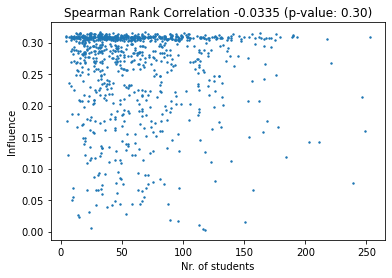

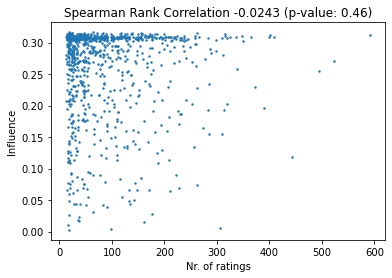

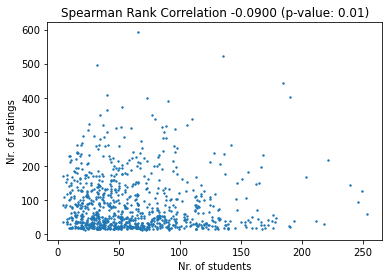

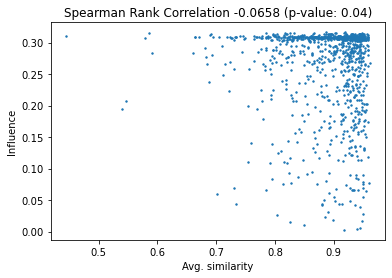

In [78]:
n_students = []
for ruid in train_df["user_id"].unique():
    iuid = trainset.to_inner_uid(ruid)
    deg = len(knn.students[iuid])
    n_students.append(deg)
n_students = np.array(n_students)

#influence = [i for i in influence if i != 0]

r, p = spearmanr(n_students, influence)
plt.figure()
plt.scatter(n_students, influence, s=2)
plt.xlabel("Nr. of students")
plt.ylabel("Influence")
plt.title("Spearman Rank Correlation %.4f (p-value: %.2f)" % (r, p))

n_ratings = train_df.groupby("user_id").size().loc[train_df["user_id"].unique()].values
r, p = spearmanr(n_ratings, influence)
plt.figure()
plt.scatter(n_ratings, influence, s=2)
plt.xlabel("Nr. of ratings")
plt.ylabel("Influence")
plt.title("Spearman Rank Correlation %.4f (p-value: %.2f)" % (r, p))

r, p = spearmanr(n_students, n_ratings)
plt.figure()
plt.scatter(n_students, n_ratings, s=2)
plt.xlabel("Nr. of students")
plt.ylabel("Nr. of ratings")
plt.title("Spearman Rank Correlation %.4f (p-value: %.2f)" % (r, p))

avg_similarity = np.mean(sim, axis=0)[[trainset.to_inner_uid(ruid) for ruid in train_df["user_id"].unique()]]
r, p = spearmanr(avg_similarity, influence)
plt.figure()
plt.scatter(avg_similarity, influence, s=2)
plt.xlabel("Avg. similarity")
plt.ylabel("Influence")
plt.title("Spearman Rank Correlation %.4f (p-value: %.2f)" % (r, p))

In [79]:
top_mentors = sorted(list(zip(n_students, influence)), key=lambda t: t[0], reverse=True)[:10]
print("[Avg. Influence] Highest degree mentors: %0.4f, All mentors: %0.4f" % (np.mean([infl for deg, infl in top_mentors]), np.mean(influence)))

top_mentors = sorted(list(zip(n_students, influence)), key=lambda t: t[1], reverse=True)[:10]
print("[Avg. Degree] Highest influential mentors: %0.4f, All mentors: %0.4f" % (np.mean([deg for deg, infl in top_mentors]), np.mean(n_students)))

[Avg. Influence] Highest degree mentors: 0.2239, All mentors: 0.2597
[Avg. Degree] Highest influential mentors: 55.0000, All mentors: 61.7837


# KNN similarity, reuse

In [46]:
BEST_K = 7

In [47]:
sim = UserKNN().compute_similarities(trainset, min_support=1)
pop = UserKNN().compute_popularities(trainset)
gain = UserKNN().compute_gain(trainset)

knn = UserKNN(k=BEST_K, precomputed_sim=sim, reuse=True)
knn.fit(trainset)
predictions = knn.test(testset)
mae = accuracy.mae(predictions, verbose=False)

topn = get_top_n(predictions, n=10)

In [81]:
influence = np.zeros(train_df["user_id"].nunique())
s = dt.now()
i = 1
for ruid in train_df["user_id"].unique():
    train_without_u_df = train_df[train_df["user_id"] != ruid]
    raw_trainset = [(ruid, riid, r, None) for ruid, riid, r in train_without_u_df.to_records(index=False)]
    trainset_without_u = Dataset.construct_trainset(dataset, raw_trainset)
    
    sim = UserKNN().compute_similarities(trainset_without_u, min_support=1)
    pop = UserKNN().compute_popularities(trainset_without_u)
    gain = UserKNN().compute_gain(trainset_without_u)
    
    model_without_u = UserKNN(k=BEST_K, precomputed_sim=sim, reuse=True)
    model_without_u.fit(trainset_without_u)
    predictions_without_u = model_without_u.test(testset)
    
    topn_without_u = get_top_n(predictions_without_u, n=10)
    jdists = []
    for uid in topn_without_u.keys():
        jdist = 1 - len(set(topn_without_u[uid]).intersection(topn[uid])) / len(set(topn_without_u[uid]).union(topn[uid]))
        jdists.append(jdist)
    influence[ruid] = np.mean(jdists)
    
    print("[%f%% Done] Time elapsed %s, Influence %f" % (100 * i / train_df["user_id"].nunique(), dt.now() - s, influence[ruid]))
    
    i += 1

KeyboardInterrupt: 

Text(0.5, 1.0, 'Spearman Rank Correlation 0.0297 (p-value: 0.36)')

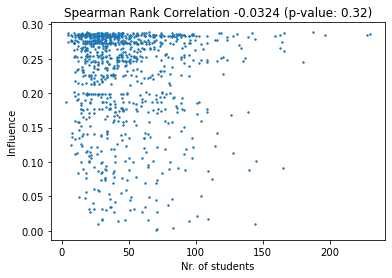

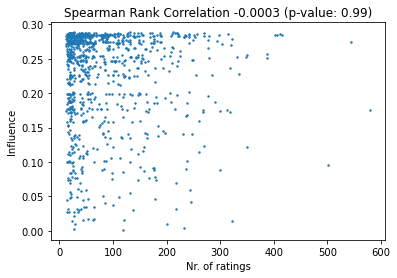

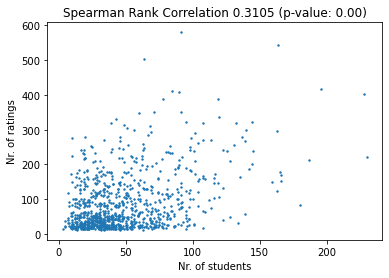

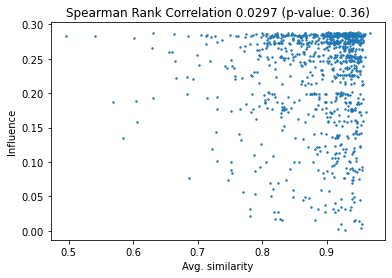

In [69]:
n_students = []
for ruid in train_df["user_id"].unique():
    iuid = trainset.to_inner_uid(ruid)
    deg = len(knn.students[iuid])
    n_students.append(deg)
n_students = np.array(n_students)

r, p = spearmanr(n_students, influence)
plt.figure()
plt.scatter(n_students, influence, s=2)
plt.xlabel("Nr. of students")
plt.ylabel("Influence")
plt.title("Spearman Rank Correlation %.4f (p-value: %.2f)" % (r, p))

n_ratings = train_df.groupby("user_id").size().loc[train_df["user_id"].unique()].values
r, p = spearmanr(n_ratings, influence)
plt.figure()
plt.scatter(n_ratings, influence, s=2)
plt.xlabel("Nr. of ratings")
plt.ylabel("Influence")
plt.title("Spearman Rank Correlation %.4f (p-value: %.2f)" % (r, p))

r, p = spearmanr(n_students, n_ratings)
plt.figure()
plt.scatter(n_students, n_ratings, s=2)
plt.xlabel("Nr. of students")
plt.ylabel("Nr. of ratings")
plt.title("Spearman Rank Correlation %.4f (p-value: %.2f)" % (r, p))

avg_similarity = np.mean(sim, axis=0)[[trainset.to_inner_uid(ruid) for ruid in train_df["user_id"].unique()]]
r, p = spearmanr(avg_similarity, influence)
plt.figure()
plt.scatter(avg_similarity, influence, s=2)
plt.xlabel("Avg. similarity")
plt.ylabel("Influence")
plt.title("Spearman Rank Correlation %.4f (p-value: %.2f)" % (r, p))

In [70]:
top_mentors = sorted(list(zip(n_students, influence)), key=lambda t: t[0], reverse=True)[:10]
print("[Avg. Influence] Highest degree mentors: %0.4f, All mentors: %0.4f" % (np.mean([infl for deg, infl in top_mentors]), np.mean(influence)))

top_mentors = sorted(list(zip(n_students, influence)), key=lambda t: t[1], reverse=True)[:10]
print("[Avg. Degree] Highest influential mentors: %0.4f, All mentors: %0.4f" % (np.mean([deg for deg, infl in top_mentors]), np.mean(n_students)))

[Avg. Influence] Highest degree mentors: 0.2570, All mentors: 0.2247
[Avg. Degree] Highest influential mentors: 69.0000, All mentors: 47.3860


In [90]:
sum(influence)

211.89534293279922

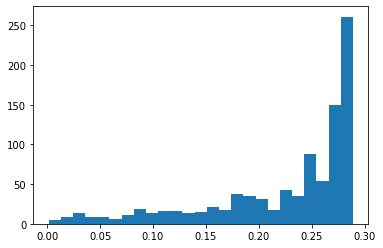

In [81]:
plt.hist(influence, bins=25);

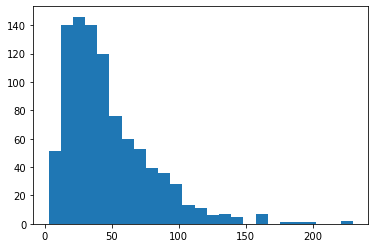

In [83]:
plt.hist(n_students, bins=25);

In [93]:
top_influencers = np.argsort(n_students)[-10:]
top_influencers_df = train_df[train_df["user_id"].isin(top_influencers)]
top_influencers_df.groupby("user_id").size().mean(), train_df.groupby("user_id").size().mean()

(141.6, 84.83457051961824)

In [92]:
top_mentors = np.argsort(n_students)[-10:]
np.mean(avg_similarity[top_mentors]), np.mean(avg_similarity)

(0.9343636968887774, 0.8879353047062929)